## Deep Convolutional GAN on Fashion-MNIST

In this notebook, we build and train a Deep Convolutional Generative Adversarial Network (DCGAN) to generate realistic 28×28 grayscale images of clothing from the Fashion-MNIST dataset. We’ll walk through data preprocessing, model definitions, training routines, and visualize the results as both static samples and an animated GIF.


In [1]:
%pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow import keras
import tensorflow as tf

from IPython import display

2025-06-04 22:18:54.075332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-04 22:18:54.096535: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-04 22:18:54.102956: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-04 22:18:54.121600: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-04 22:18:54.936571: W tensorflow/compiler/tf2

### Load the Fashion-MNIST dataset

In [3]:
fashion_mnist = keras.datasets.fashion_mnist.load_data()
(mnist_images, mnist_labels), (mnist_images_test, mnist_labels_test) = fashion_mnist

In [4]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

### Data Preprocessing

In [5]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices((mnist_images, mnist_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2025-06-04 22:18:57.463634: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### Define the Generator Model
The generator model takes random noise as input and generates images. It uses transposed convolutional layers to upsample the noise into a 28x28 image.

In [6]:
def make_generator_model():
    model = keras.Sequential()
    # Start with an Input layer as recommended
    model.add(layers.Input(shape=(100,)))
    model.add(layers.Dense(7*7*256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Use Reshape instead of reshape
    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)
    return model

### Generate an Image
The following code generates a random image using the generator model. It creates a noise vector of shape (1, 100) and passes it through the generator to produce an image.

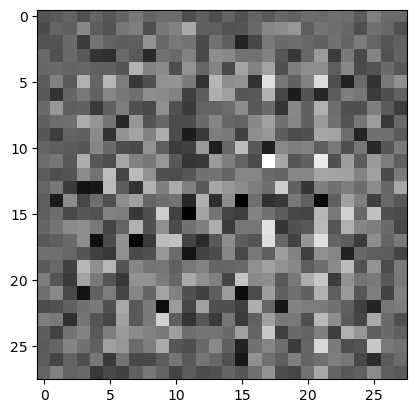

In [7]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Define the Discriminator
The discriminator is a convolutional neural network that classifies images as real (from the dataset) or fake (generated by the generator). It uses convolutional layers, LeakyReLU activations, and dropout for regularization.

In [8]:
def make_discriminator_model():
    model = keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [9]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00069425]], shape=(1, 1), dtype=float32)


/opt/conda/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Define Loss Functions
The loss function for the discriminator is binary cross-entropy, which measures how well the discriminator distinguishes between real and fake images. The generator's loss is also based on binary cross-entropy, where it tries to fool the discriminator into classifying generated images as real.

In [10]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Training Loop

In [13]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

### Training step
The training step involves generating fake images from random noise, passing both real and fake images through the discriminator, calculating losses for both the generator and discriminator, and applying gradients to update their weights.

In [14]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

### Train the Model
This function iterates through the dataset for a specified number of epochs, calling the `train_step` function for each batch of images. It also generates and saves images at the end of each epoch to visualize the generator's progress.

In [15]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

            #Produce Gif
            display.clear_output(wait=True)
            generate_and_save_images(generator, epoch + 1, seed)

            print('Time taken for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, seed)

### Generate and Save Images
This is just for visualization purposes. It generates images from the generator model and saves them to disk. The images are displayed in a grid format.

In [16]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [17]:
train(train_dataset, EPOCHS)

Time taken for epoch 1 is 12.204609870910645 sec


KeyboardInterrupt: 

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

### Create an animated GIF

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)
